In [ ]:
# pip install pandas numpy scikit-learn matplotlib tensorflow

In [1]:
import pandas as pd
import numpy as np
import IPython
import IPython.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, Flatten, Attention
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [2]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPricesMerged.csv')

In [3]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data.head()

Price  neg_oil  neu_oil  pos_oil  compound_oil  neg_war  \
Date                                                                      
2023-04-03  84.930000    0.000    0.000    0.000        0.0000    0.000   
2023-04-04  84.940002    0.000    0.000    0.000        0.0000    0.000   
2023-04-05  84.989998    0.000    0.000    0.000        0.0000    0.000   
2023-04-06  85.120003    0.000    0.000    0.000        0.0000    0.000   
2023-04-10  84.180000    0.086    0.816    0.098        0.9796    0.144   

            neu_war  pos_war  compound_war  
Date                                        
2023-04-03    0.000    0.000        0.0000  
2023-04-04    0.000    0.000        0.0000  
2023-04-05    0.000    0.000        0.0000  
2023-04-06    0.776    0.224        0.9866  
2023-04-10    0.708    0.147       -0.1356

In [5]:
data.describe().transpose()

count       mean       std        min        25%        50%  \
Price         271.0  82.667343  5.567707  71.839996  78.139999  82.739998   
neg_oil       271.0   0.023033  0.024112   0.000000   0.000000   0.017500   
neu_oil       271.0   0.496814  0.361231   0.000000   0.000000   0.604750   
pos_oil       271.0   0.064340  0.055087   0.000000   0.000000   0.062000   
compound_oil  271.0   0.378112  0.429797  -0.955900   0.000000   0.270900   
neg_war       271.0   0.082097  0.071262   0.000000   0.013000   0.073000   
neu_war       271.0   0.802173  0.128576   0.000000   0.773586   0.817200   
pos_war       271.0   0.104691  0.065619   0.000000   0.066000   0.118000   
compound_war  271.0   0.163507  0.595739  -0.999900  -0.357750   0.115525   

                    75%        max  
Price         86.355000  96.550003  
neg_oil        0.038271   0.116000  
neu_oil        0.831000   0.960000  
pos_oil        0.100667   0.181000  
compound_oil   0.950900   0.999900  
neg_war        0.132375   0.272500  
neu_war        0.854250   1.000000  
pos_war        0.139875   0.435000  
compound_war   0.701659   0.986600

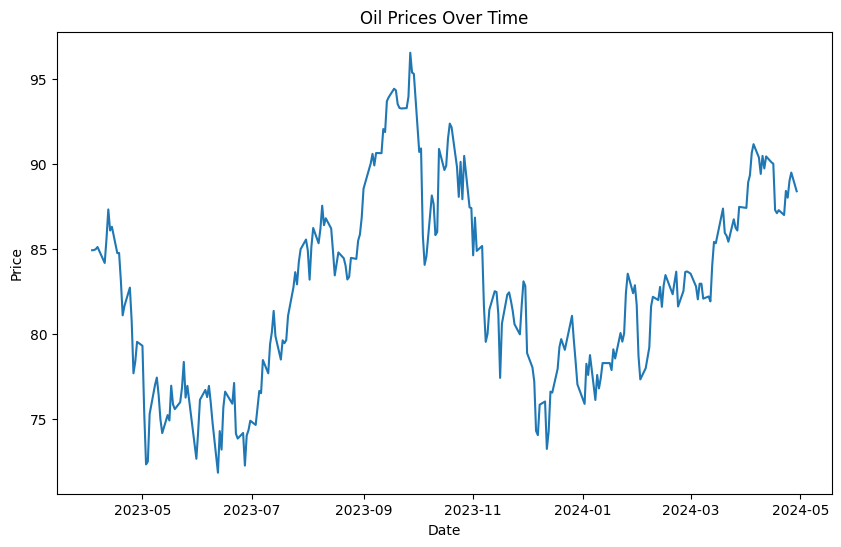

In [6]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [7]:
column_indices = {name: i for i, name in enumerate(data.columns)}
column_indices

{'Price': 0,
 'neg_oil': 1,
 'neu_oil': 2,
 'pos_oil': 3,
 'compound_oil': 4,
 'neg_war': 5,
 'neu_war': 6,
 'pos_war': 7,
 'compound_war': 8}

In [8]:
# Extract the relevant columns for oil sentiment data
# oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
# oil_data = data[['Price']]
oil_data = data[['Price', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
oil_data.head()

Price  neg_war  neu_war  pos_war  compound_war
Date                                                          
2023-04-03  84.930000    0.000    0.000    0.000        0.0000
2023-04-04  84.940002    0.000    0.000    0.000        0.0000
2023-04-05  84.989998    0.000    0.000    0.000        0.0000
2023-04-06  85.120003    0.000    0.776    0.224        0.9866
2023-04-10  84.180000    0.144    0.708    0.147       -0.1356

In [ ]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))
# oil_data = scaler.fit_transform(oil_data)

In [10]:
n = len(oil_data)
train_df = oil_data[0:int(n*0.7)]
val_df = oil_data[int(n*0.7):int(n*0.875)]
test_df = oil_data[int(n*0.875):]

In [12]:
# train = 70%
# validation = 17.5%
# test - 12.5%

In [11]:
test_df

Price   neg_war   neu_war   pos_war  compound_war
Date                                                            
2024-03-12  0.407932  0.071857  0.851857  0.076143      0.179357
2024-03-13  0.493323  0.036273  0.807909  0.155818      0.705418
2024-03-14  0.549575  0.108250  0.792000  0.099500     -0.081150
2024-03-15  0.546337  0.100200  0.755400  0.144600      0.096620
2024-03-18  0.609065  0.057000  0.798000  0.144750      0.526450
2024-03-19  0.628895  0.097000  0.817200  0.086000     -0.166800
2024-03-20  0.571024  0.098500  0.777750  0.123750      0.429700
2024-03-21  0.564144  0.055833  0.812833  0.131333      0.495367
2024-03-22  0.549980  0.070000  0.777400  0.152400      0.194400
2024-03-25  0.603399  0.113733  0.781200  0.105067     -0.017160
2024-03-26  0.583165  0.105700  0.795200  0.099000     -0.026010
2024-03-27  0.576689  0.043750  0.767000  0.189500      0.464950
2024-03-28  0.632942  0.058875  0.854500  0.086625      0.265012
2024-04-01  0.630514  0.076667  0.837444  0.086222     -0.134400
2024-04-02  0.691218  0.068200  0.846600  0.085400      0.444340
2024-04-03  0.708620  0.060111  0.814333  0.125333      0.494444
2024-04-04  0.761230  0.083400  0.791600  0.125000      0.088140
2024-04-05  0.782274  0.076300  0.788400  0.135100      0.504890
2024-04-08  0.750303  0.080714  0.792571  0.127000      0.060300
2024-04-09  0.711453  0.068800  0.764000  0.167500      0.653670
2024-04-10  0.754351  0.096500  0.840750  0.062625     -0.415650
2024-04-11  0.724403  0.070375  0.795875  0.133625      0.249362
2024-04-12  0.753136  0.025500  0.835000  0.139750      0.550375
2024-04-15  0.738972  0.072714  0.782143  0.145143      0.240714
2024-04-16  0.735734  0.126909  0.748000  0.125000     -0.092182
2024-04-17  0.625253  0.105286  0.817143  0.077571     -0.119057
2024-04-18  0.617968  0.105000  0.778000  0.117111      0.099789
2024-04-19  0.625253  0.099900  0.813800  0.086300      0.015280
2024-04-22  0.613517  0.056111  0.811667  0.132222      0.363278
2024-04-23  0.670983  0.087400  0.816400  0.096300      0.111540
2024-04-24  0.654795  0.118571  0.774571  0.106714      0.012629
2024-04-25  0.694860  0.099000  0.824700  0.076400     -0.110820
2024-04-26  0.714690  0.056111  0.830778  0.113111      0.154800
2024-04-29  0.670174  0.074444  0.788222  0.137444      0.425656

In [12]:
len(train_df),len(val_df),len(test_df)

(189, 48, 34)

In [13]:
train_df.columns

Index(['Price', 'neg_war', 'neu_war', 'pos_war', 'compound_war'], dtype='object')

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def all_data(self):
  return self.make_dataset(oil_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.all_data = all_data
WindowGenerator.example = example

In [18]:
val_performance = {}
performance = {}
histories={}
models_list={}
windows_list={}

windows_dictionary = {
    'weekly': 7, 
    'bi-weekly': 14, 
    'monthly': 30,       
}


In [19]:
for w in windows_dictionary:
    input_width=windows_dictionary[w]
    window = WindowGenerator(
        input_width=input_width, label_width=1, shift=1,
        label_columns=['Price']
    )
    windows_list[w]=window

In [20]:
windows_list

{'weekly': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price'],
 'bi-weekly': Total window size: 15
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 Label indices: [14]
 Label column name(s): ['Price'],
 'monthly': Total window size: 31
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29]
 Label indices: [30]
 Label column name(s): ['Price']}

In [21]:
windows_list['monthly']

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [22]:
MAX_EPOCHS = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

def compile_and_fit(model, window, patience=4):
  model.compile(
    # loss='mean_absolute_percentage_error',
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=[
      tf.keras.metrics.MeanAbsolutePercentageError(),
      # tf.keras.metrics.MeanSquaredError()
      tf.keras.metrics.MeanAbsoluteError(),
    ]
  )

  history = model.fit(
    window.train, 
    epochs=MAX_EPOCHS, 
    validation_data=window.val,
    callbacks=[early_stopping,reduce_lr]
  )

  return history

1. Linear model

In [23]:
train_df.shape

(189, 5)

In [24]:
window=windows_list['monthly']
seq_length=30
input_shape=(seq_length, train_df.shape[1])
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [25]:
input_shape

(30, 5)

In [26]:
# linear = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=1, input_shape=input_shape)
# ])

def get_lstm_model_1(input_shape):
    # 3. Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model
# linear=get_ensemble_model2(input_shape)
model=get_lstm_model_1(input_shape)
# model=get_transformer_model(input_shape)

In [27]:
history = compile_and_fit(model, window)

histories_Linear = history
val_performance_Linear = model.evaluate(window.val, return_dict=True)
performance_Linear = model.evaluate(window.test, verbose=1, return_dict=True)

Epoch 1/100
159/159 [==============================] - 6s 15ms/step - loss: 0.0256 - mean_absolute_percentage_error: 978066.5000 - mean_absolute_error: 0.1264 - val_loss: 0.0687 - val_mean_absolute_percentage_error: 58.4239 - val_mean_absolute_error: 0.2603 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 2s 10ms/step - loss: 0.0290 - mean_absolute_percentage_error: 1205124.7500 - mean_absolute_error: 0.1369 - val_loss: 0.0380 - val_mean_absolute_percentage_error: 43.1286 - val_mean_absolute_error: 0.1926 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 2s 10ms/step - loss: 0.0313 - mean_absolute_percentage_error: 800917.3750 - mean_absolute_error: 0.1409 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 29.1513 - val_mean_absolute_error: 0.1307 - lr: 0.0010
Epoch 4/100
159/159 [==============================] - 2s 10ms/step - loss: 0.0251 - mean_absolute_percentage_error: 825744.6250 - mean_absolute_error: 0.1286 - val_loss: 0.0292 - val_me

In [31]:
histories_Linear.history.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'lr'])

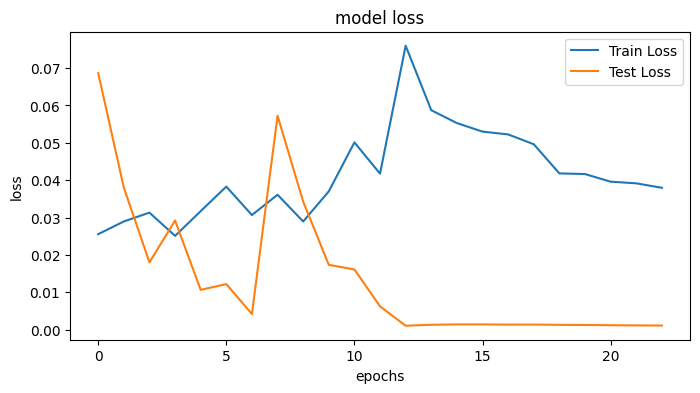

In [28]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(histories_Linear.history['loss'], label='Train Loss')
plt.plot(histories_Linear.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
# plt.savefig('outputs/reddit oil + war - lstm model 01 model loss.png')
plt.show()

In [29]:
all_predict = model.predict(window.all_data)
all_predict

241/241 [==============================] - 1s 2ms/step


array([[0.456116  ],
       [0.46057373],
       [0.46605483],
       [0.4692483 ],
       [0.47153002],
       [0.47379762],
       [0.47626442],
       [0.47925186],
       [0.47970343],
       [0.4807646 ],
       [0.47880077],
       [0.4769831 ],
       [0.47631437],
       [0.4767796 ],
       [0.47730315],
       [0.47716004],
       [0.47747535],
       [0.47670507],
       [0.47511837],
       [0.46664992],
       [0.45803386],
       [0.4457993 ],
       [0.43532044],
       [0.424738  ],
       [0.41241276],
       [0.4010694 ],
       [0.3851188 ],
       [0.3687903 ],
       [0.37777707],
       [0.3907442 ],
       [0.40570003],
       [0.41864973],
       [0.41978616],
       [0.42541343],
       [0.4348539 ],
       [0.44286573],
       [0.45132223],
       [0.45701236],
       [0.46301618],
       [0.4680518 ],
       [0.4728717 ],
       [0.47507426],
       [0.47569364],
       [0.47723815],
       [0.478261  ],
       [0.47929728],
       [0.48128906],
       [0.484

In [30]:
all_predict.shape

(241, 1)

In [31]:
X_all_data = scaler.inverse_transform(all_predict)
# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

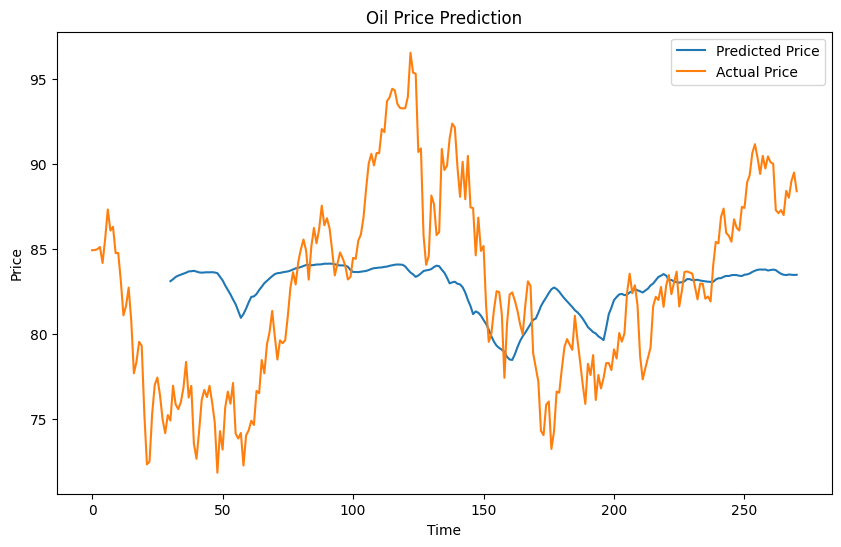

In [32]:
# Plot predictions vs actual values
seq_length = 30

plt.figure(figsize=(10, 6))

plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
# plt.savefig('outputs/lstm model 01 Oil Price Prediction.png')
plt.show()

In [33]:

def get_lstm_model_1(input_shape):
    # 3. Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model

In [34]:

def get_lstm_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(units=60, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))

    return model

In [35]:

def get_lstm_model_3(input_shape):
    input = keras.Input(shape=input_shape)

    layer = LSTM(units=60, return_sequences=True)(input)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=50, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=40, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=30, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=30, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=20, return_sequences=False)(layer)
    layer = Dropout(0.2)(layer)
    output = Dense(units=1)(layer)

    model=keras.Model(input, output)


    return model

In [36]:
def get_lstm_model_4(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    return model

In [37]:
def get_lstm_model_5(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [38]:

def get_bidirectional_lstm_model_1(input_shape):
    model = Sequential()
    model.add(LSTM(units=20, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=20, return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=10, return_sequences=False)))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))

    return model

In [39]:
def get_bidirectional_lstm_model_2(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(100, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    return model

def get_bidirectional_lstm_model_3(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def get_bidirectional_lstm_model_4(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [40]:
def get_stacked_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    return model

In [41]:
def get_attention_lstm_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    lstm_out = LSTM(50, return_sequences=True)(inputs)
    attention = Attention()([lstm_out, lstm_out])
    dense = Dense(1)(attention)
    model = tf.keras.Model(inputs=inputs, outputs=dense)
    return model

In [42]:
models_name_list={
    'lstm_model_1' : get_lstm_model_1 ,
    'lstm_model_2' : get_lstm_model_2 ,
    'lstm_model_3' : get_lstm_model_3 ,
    'lstm_model_4' : get_lstm_model_4 ,
    'lstm_model_4' : get_lstm_model_5 ,
    'bidirectional_lstm_model_1' : get_bidirectional_lstm_model_1 ,
    'bidirectional_lstm_model_2' : get_bidirectional_lstm_model_2 ,
    'bidirectional_lstm_model_3' : get_bidirectional_lstm_model_3 ,
    'bidirectional_lstm_model_4' : get_bidirectional_lstm_model_4 ,
    'stacked_lstm_model' : get_stacked_lstm_model ,
    'attention_lstm_model' : get_attention_lstm_model ,
}
models_list={}

In [43]:
for model_type in models_name_list:
    print(model_type)

lstm_model_1
lstm_model_2
lstm_model_3
lstm_model_4
bidirectional_lstm_model_1
bidirectional_lstm_model_2
bidirectional_lstm_model_3
bidirectional_lstm_model_4
stacked_lstm_model
attention_lstm_model


In [44]:
def create_model_for_each_model_type(model_type):
    for window_name in windows_dictionary:
        seq_length=windows_dictionary[window_name]
        window = windows_list[window_name]
        input_shape=(seq_length, train_df.shape[1])


        model_name=f'{model_type}_{window_name}'
        print('\n\n\n--------------',model_name, input_shape, '--------------')
        model = models_name_list[model_type](input_shape)
        print(model.summary())
        
        models_list[model_name]= {
            'model':model,
            'window':window,
            'seq_length':seq_length

        }


In [45]:
for model_type in models_name_list:
    print('\n------------',model_type,'------------')
    create_model_for_each_model_type(model_type)


------------ lstm_model_1 ------------



-------------- lstm_model_1_weekly (7, 5) --------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 50)             11200     
                                                                 
 dropout_2 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable para

In [46]:
models_list

{'lstm_model_1_weekly': {'model': <keras.src.engine.sequential.Sequential at 0x1ece6879810>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label column name(s): ['Price'],
  'seq_length': 7},
 'lstm_model_1_bi-weekly': {'model': <keras.src.engine.sequential.Sequential at 0x1ece69b4050>,
  'window': Total window size: 15
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Label indices: [14]
  Label column name(s): ['Price'],
  'seq_length': 14},
 'lstm_model_1_monthly': {'model': <keras.src.engine.sequential.Sequential at 0x1ece75ad050>,
  'window': Total window size: 31
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
   24 25 26 27 28 29]
  Label indices: [30]
  Label column name(s): ['Price'],
  'seq_length': 30},
 'lstm_model_2_weekly': {'model': <keras.src.engine.sequential.Sequential at 0x1ece079cf10>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7

In [47]:
len(models_list)

30

In [48]:
models_list['lstm_model_1_weekly']

{'model': <keras.src.engine.sequential.Sequential at 0x1ece6879810>,
 'window': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price'],
 'seq_length': 7}

In [49]:
model_name='lstm_model_1_weekly' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['Price']

In [50]:
for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    
    print('\n\n\n------------',model_name,'------------')
    history = compile_and_fit(model, window)

    histories[model_name] = history
    print('------------val performance')
    val_performance[model_name] = model.evaluate(window.val, return_dict=True)
    print('------------test performance')
    performance[model_name] = model.evaluate(window.test, verbose=1, return_dict=True)




------------ lstm_model_1_weekly ------------
Epoch 1/100
182/182 [==============================] - 5s 8ms/step - loss: 0.0302 - mean_absolute_percentage_error: 432987.4688 - mean_absolute_error: 0.1360 - val_loss: 0.0359 - val_mean_absolute_percentage_error: 42.6797 - val_mean_absolute_error: 0.1736 - lr: 0.0010
Epoch 2/100
182/182 [==============================] - 1s 4ms/step - loss: 0.0291 - mean_absolute_percentage_error: 624089.1250 - mean_absolute_error: 0.1370 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 34.0403 - val_mean_absolute_error: 0.1412 - lr: 0.0010
Epoch 3/100
182/182 [==============================] - 1s 4ms/step - loss: 0.0268 - mean_absolute_percentage_error: 1020705.5625 - mean_absolute_error: 0.1351 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 29.4986 - val_mean_absolute_error: 0.1237 - lr: 0.0010
Epoch 4/100
182/182 [==============================] - 1s 4ms/step - loss: 0.0270 - mean_absolute_percentage_error: 1092207.5000 - mean_abso

## evaluate

In [52]:
histories

{'lstm_model_1_weekly': <keras.src.callbacks.History at 0x1ecea29aed0>,
 'lstm_model_1_bi-weekly': <keras.src.callbacks.History at 0x1eceb469dd0>,
 'lstm_model_1_monthly': <keras.src.callbacks.History at 0x1ecf318af10>,
 'lstm_model_2_weekly': <keras.src.callbacks.History at 0x1ecf824bed0>,
 'lstm_model_2_bi-weekly': <keras.src.callbacks.History at 0x1ecff701dd0>,
 'lstm_model_2_monthly': <keras.src.callbacks.History at 0x1ed06f14b10>,
 'lstm_model_3_weekly': <keras.src.callbacks.History at 0x1ed0e0d1dd0>,
 'lstm_model_3_bi-weekly': <keras.src.callbacks.History at 0x1ed1c650510>,
 'lstm_model_3_monthly': <keras.src.callbacks.History at 0x1ed28f19dd0>,
 'lstm_model_4_weekly': <keras.src.callbacks.History at 0x1ed37e81dd0>,
 'lstm_model_4_bi-weekly': <keras.src.callbacks.History at 0x1ed3e9bfe50>,
 'lstm_model_4_monthly': <keras.src.callbacks.History at 0x1ed3e901dd0>,
 'bidirectional_lstm_model_1_weekly': <keras.src.callbacks.History at 0x1ed4cfec250>,
 'bidirectional_lstm_model_1_bi-we

In [53]:
len(histories)

30

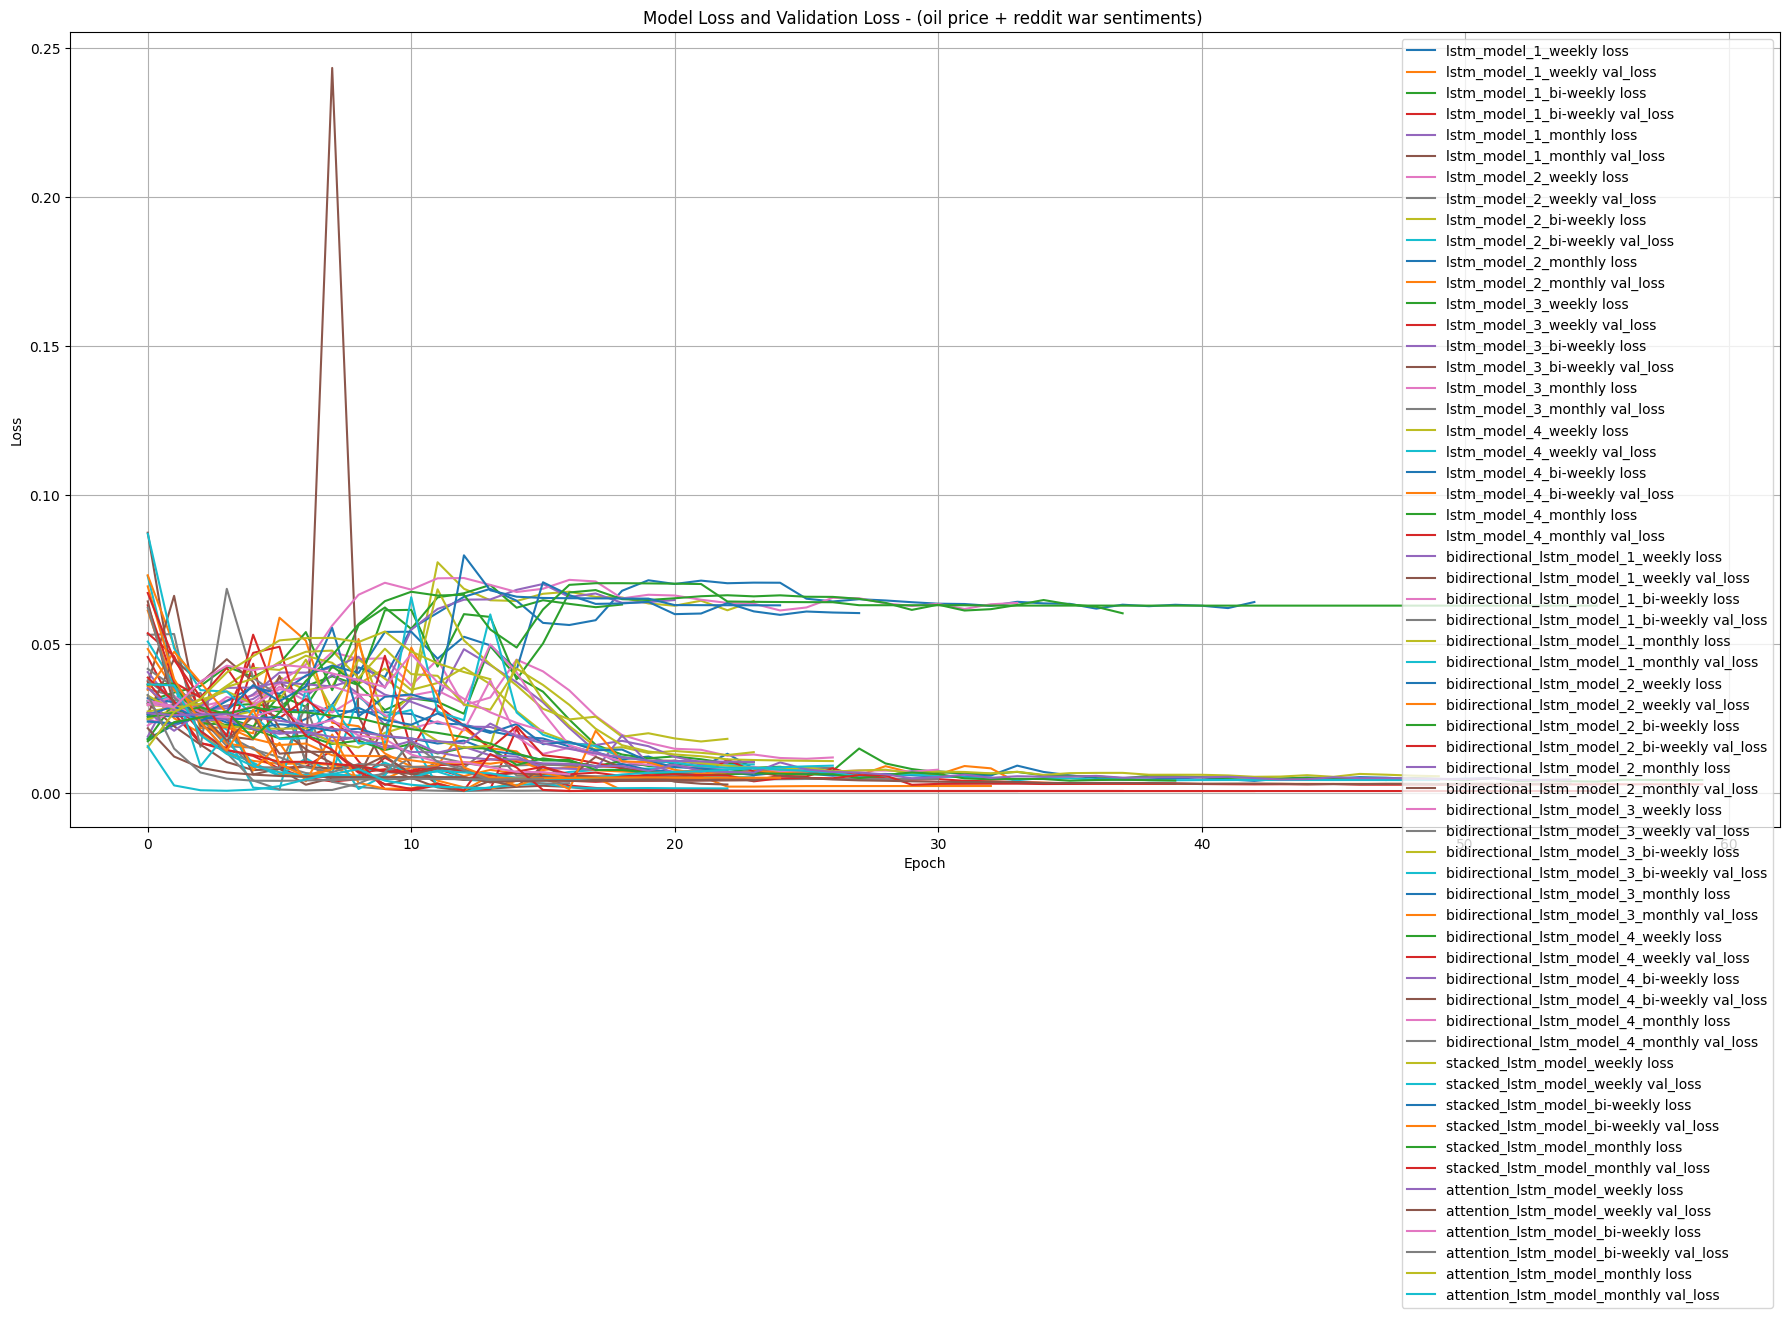

In [54]:
plt.figure(figsize=(18, 12))
for h in (histories):    # Plot Train vs Test Loss
    history=histories[h]
    plt.plot(history.history['loss'], label=f'{h} loss')
    plt.plot(history.history['val_loss'], label=f'{h} val_loss')

plt.title('Model Loss and Validation Loss - (oil price + reddit war sentiments) ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_war/LSTM model loss all models (oil price + reddit war sentiments).png')

In [55]:
val_performance

{'lstm_model_1_weekly': {'loss': 0.0022624884732067585,
  'mean_absolute_percentage_error': 10.290050506591797,
  'mean_absolute_error': 0.03492322191596031},
 'lstm_model_1_bi-weekly': {'loss': 0.0037256975192576647,
  'mean_absolute_percentage_error': 13.439355850219727,
  'mean_absolute_error': 0.043974511325359344},
 'lstm_model_1_monthly': {'loss': 0.0009610882843844593,
  'mean_absolute_percentage_error': 5.786561965942383,
  'mean_absolute_error': 0.02538461796939373},
 'lstm_model_2_weekly': {'loss': 0.005120058078318834,
  'mean_absolute_percentage_error': 16.01314926147461,
  'mean_absolute_error': 0.059789273887872696},
 'lstm_model_2_bi-weekly': {'loss': 0.00497216684743762,
  'mean_absolute_percentage_error': 15.519331932067871,
  'mean_absolute_error': 0.051476333290338516},
 'lstm_model_2_monthly': {'loss': 0.0007818600861355662,
  'mean_absolute_percentage_error': 5.441305160522461,
  'mean_absolute_error': 0.023849738761782646},
 'lstm_model_3_weekly': {'loss': 0.00691

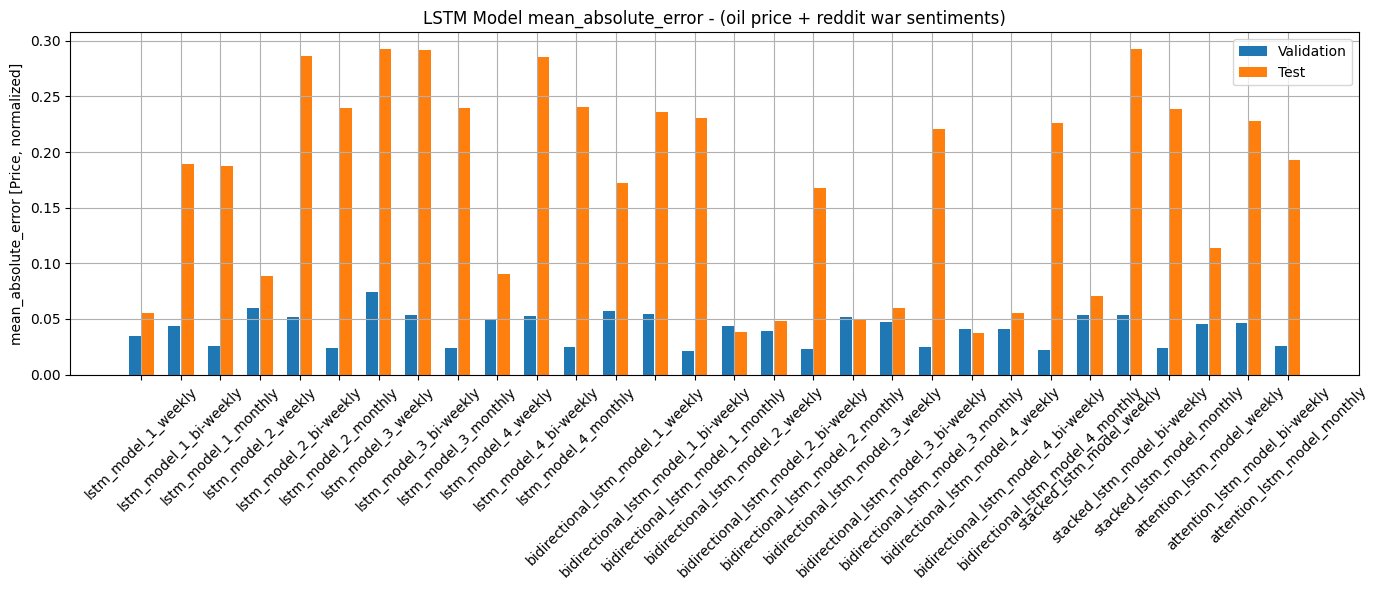

In [56]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.figure(figsize=(14, 6))
plt.title('LSTM Model mean_absolute_error - (oil price + reddit war sentiments)')
plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_war/LSTM mean_absolute_error all models (oil price + reddit war sentiments).png')

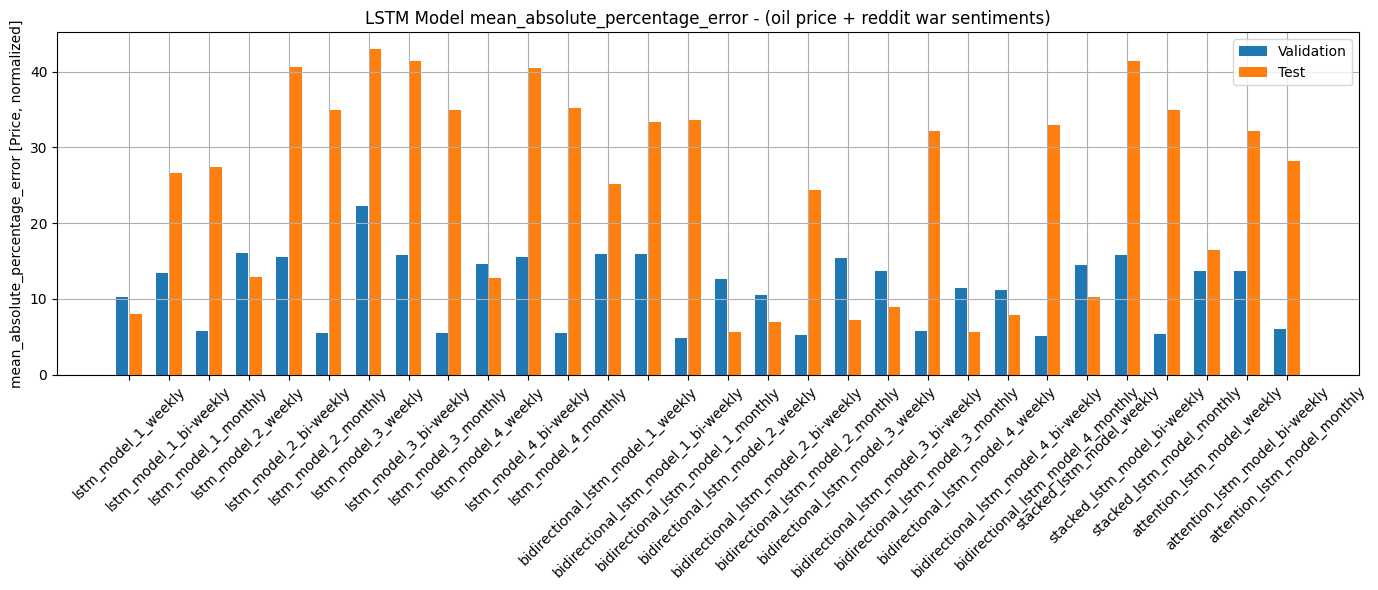

In [57]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('LSTM Model mean_absolute_percentage_error - (oil price + reddit war sentiments)')
plt.ylabel('mean_absolute_percentage_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(f'outputs/oil_reddit_war/LSTM mean_absolute_percentage_error all models (oil price + reddit war sentiments).png')

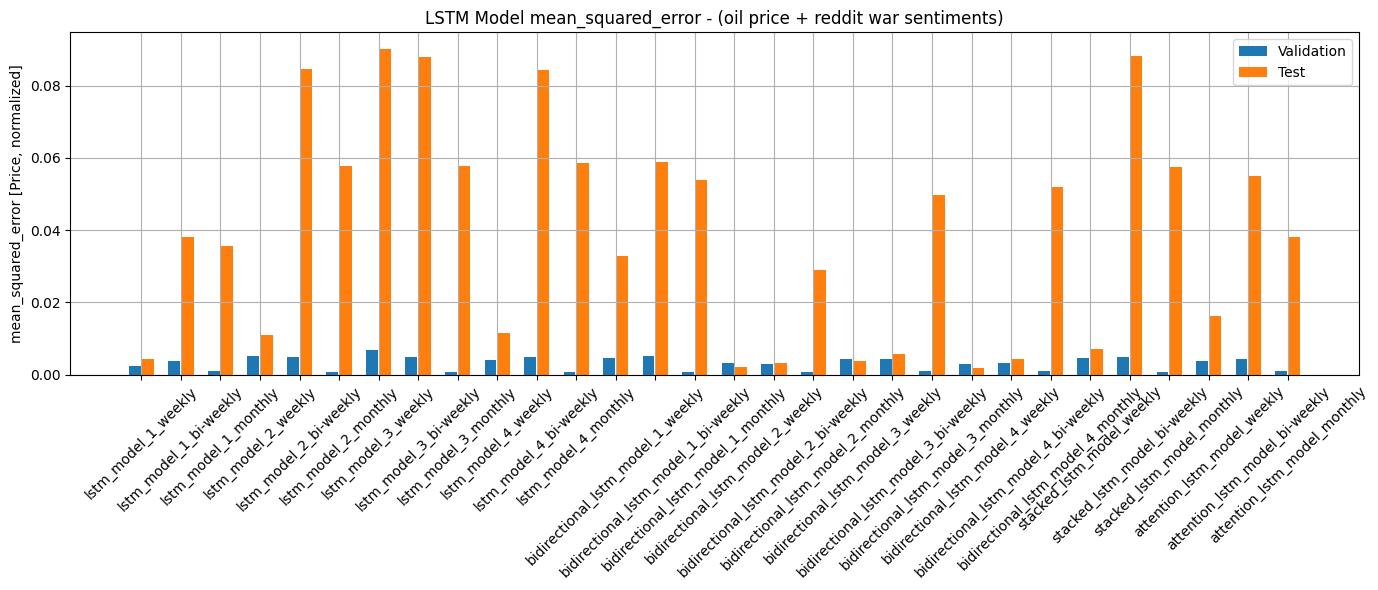

In [58]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error '
val_mae = [v['loss'] for v in val_performance.values()]
test_mae = [v['loss'] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('LSTM Model mean_squared_error - (oil price + reddit war sentiments)')
plt.ylabel('mean_squared_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(f'outputs/oil_reddit_war/LSTM mean_squared_error all models (oil price + reddit war sentiments).png')


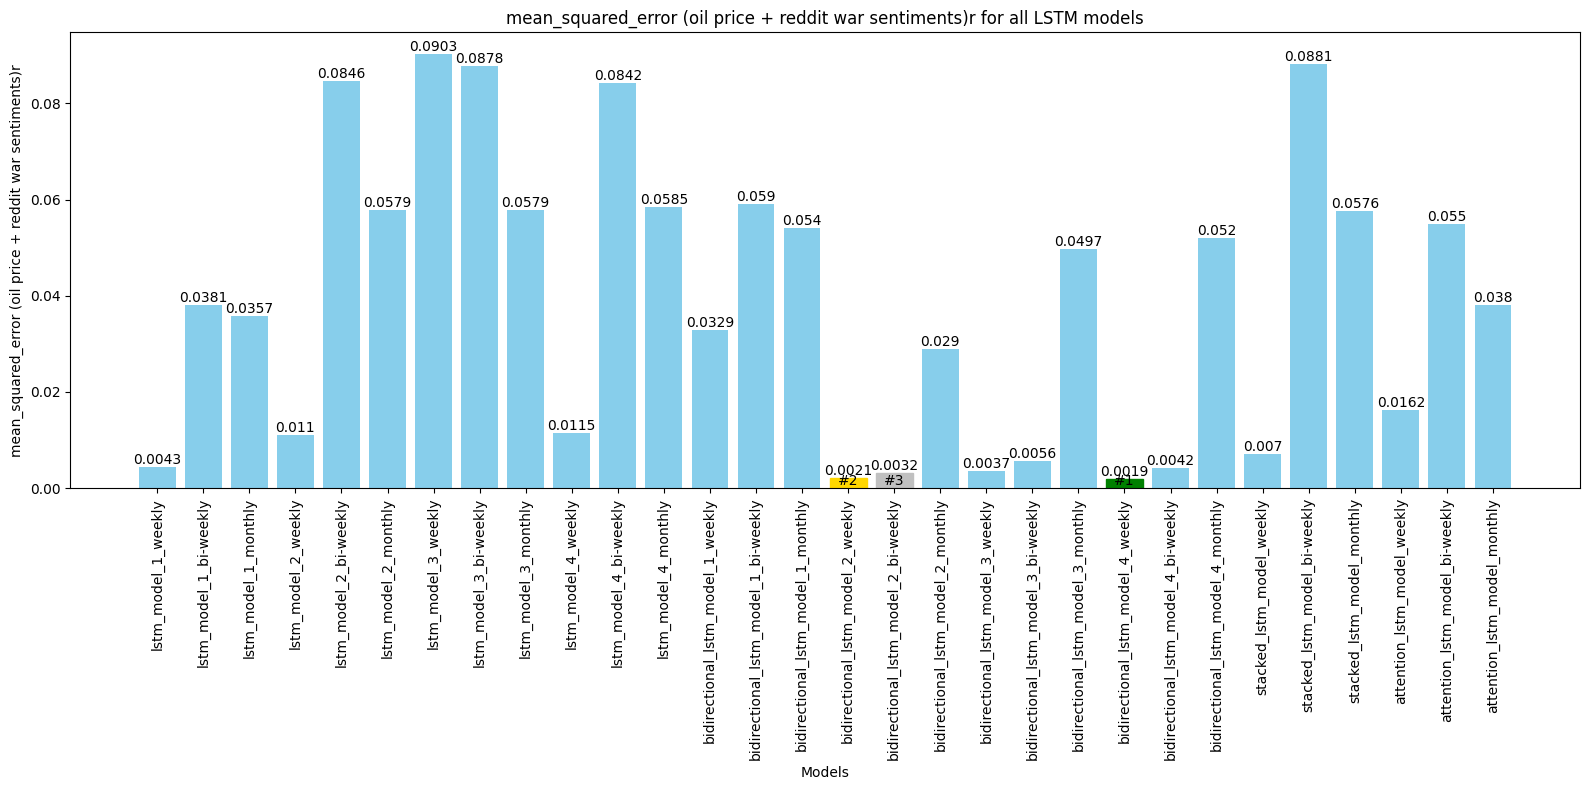

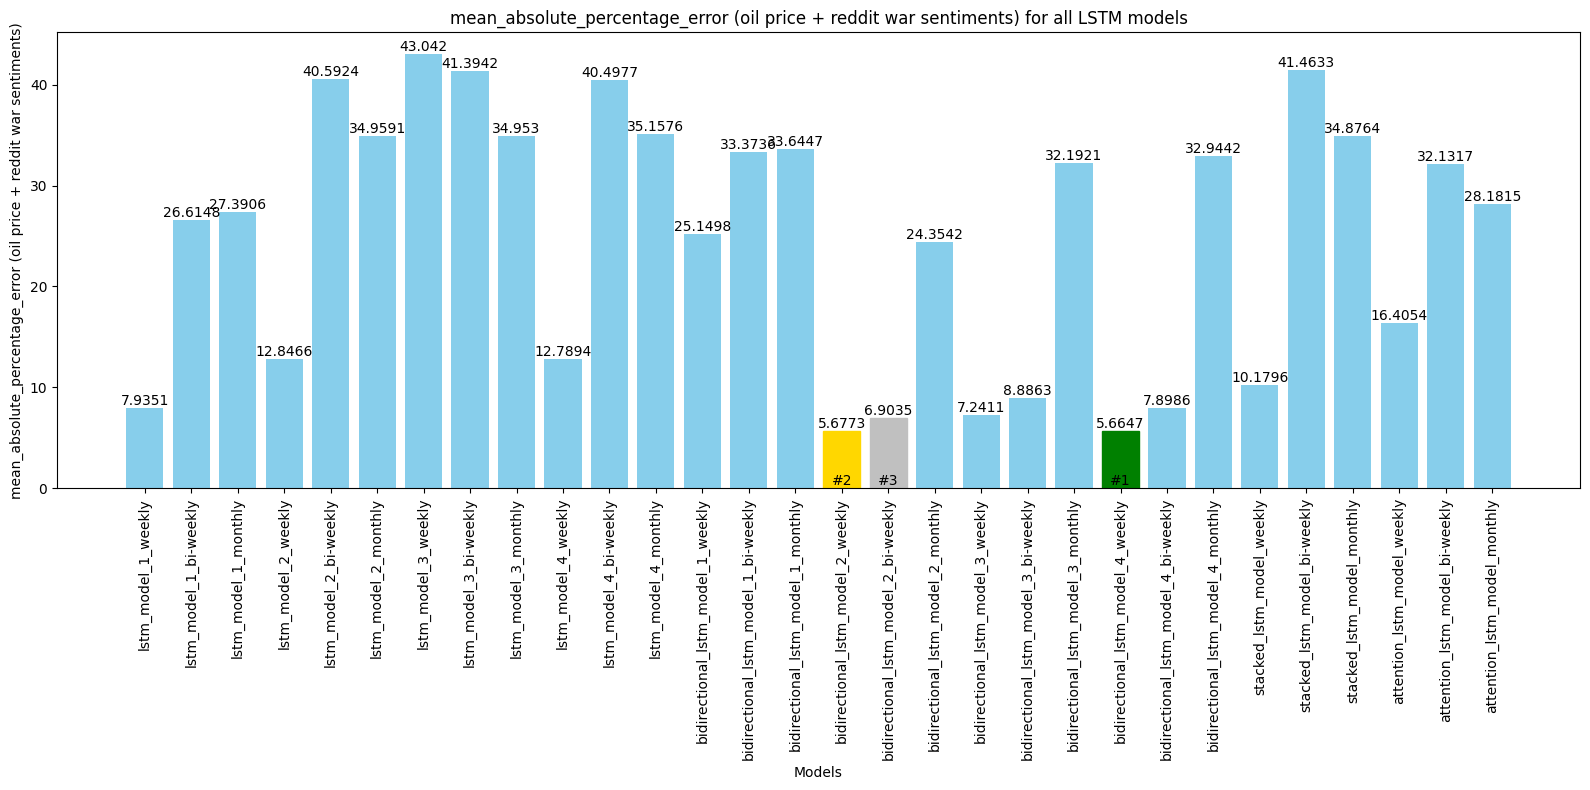

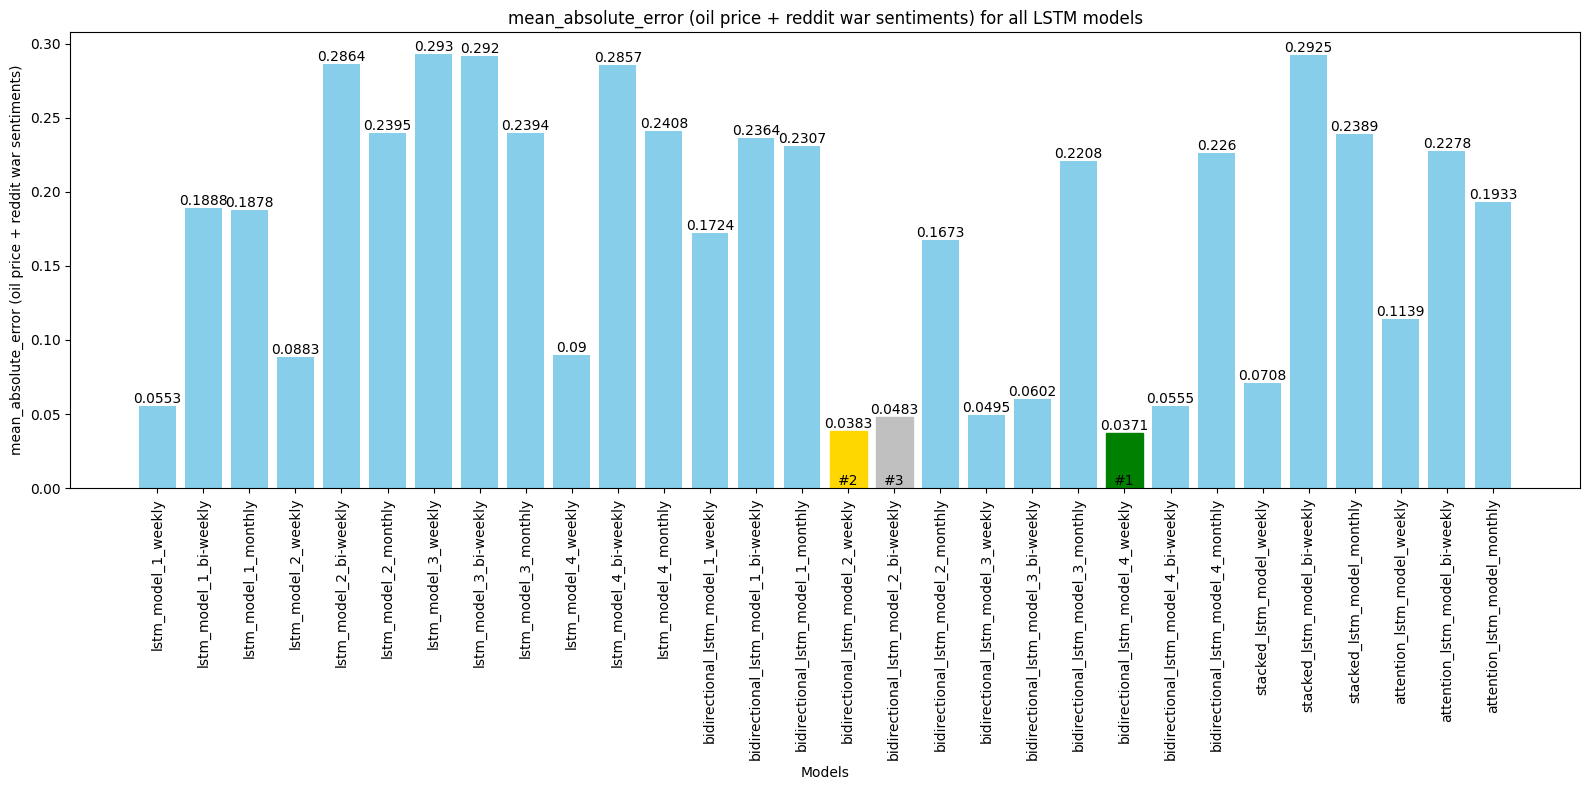

Top 3 models with minimum loss: ['bidirectional_lstm_model_4_weekly', 'bidirectional_lstm_model_2_weekly', 'bidirectional_lstm_model_2_bi-weekly']
Top 3 models with minimum mean_absolute_error: ['bidirectional_lstm_model_4_weekly', 'bidirectional_lstm_model_2_weekly', 'bidirectional_lstm_model_2_bi-weekly']
Top 3 models with minimum mean_squared_error: ['bidirectional_lstm_model_4_weekly', 'bidirectional_lstm_model_2_weekly', 'bidirectional_lstm_model_2_bi-weekly']


In [66]:
# Extract data for each metric
models = list(performance.keys())
loss_values = [performance[model]['loss'] for model in models]
mae_values = [performance[model]['mean_absolute_percentage_error'] for model in models]
mse_values = [performance[model]['mean_absolute_error'] for model in models]

# Function to plot and save a metric, highlighting the best model
def plot_and_save_metric(metric_values, metric_name, best_models_indices):
    plt.figure(figsize=(16, 8))
    bars = plt.bar(models, metric_values, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for all LSTM models')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Highlight the best models with different colors
    colors = ['green', 'gold', 'silver']
    for rank, index in enumerate(best_models_indices):
        bars[index].set_color(colors[rank])
        yval = bars[index].get_height()

        plt.text(bars[index].get_x() + bars[index].get_width()/2,  0, f'#{rank+1}', ha='center', va='bottom')

    # Annotate all bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    plt.savefig(f'outputs/oil_reddit_war/LSTM {metric_name}_comparison.png')
    plt.show()

# Find the indices of the top 3 models with the minimum values for each metric
top_n = 3

min_loss_indices = np.argsort(loss_values)[:top_n]
min_mae_indices = np.argsort(mae_values)[:top_n]
min_mse_indices = np.argsort(mse_values)[:top_n]
# Plot and save loss
plot_and_save_metric(loss_values, 'mean_squared_error (oil price + reddit war sentiments)r', min_loss_indices)

# Plot and save mean_absolute_error
plot_and_save_metric(mae_values, 'mean_absolute_percentage_error (oil price + reddit war sentiments)', min_mae_indices)

# Plot and save mean_squared_error
plot_and_save_metric(mse_values, 'mean_absolute_error (oil price + reddit war sentiments)', min_mse_indices)

# Get the model names for the top 3 models
min_loss_models = [models[i] for i in min_loss_indices]
min_mae_models = [models[i] for i in min_mae_indices]
min_mse_models = [models[i] for i in min_mse_indices]

print(f'Top {top_n} models with minimum loss: {min_loss_models}')
print(f'Top {top_n} models with minimum mean_absolute_error: {min_mae_models}')
print(f'Top {top_n} models with minimum mean_squared_error: {min_mse_models}')

In [60]:
model_name='lstm_model_1_weekly' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
seq_length = models_list[model_name]['seq_length']

In [61]:
window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['Price']

In [62]:
seq_length

7

In [63]:
all_predict = model.predict(window.all_data)
print(all_predict.shape)

264/264 [==============================] - 1s 1ms/step
(264, 1)


In [64]:
all_predict[0]

array([0.53407353], dtype=float32)

264/264 [==============================] - 0s 1ms/step


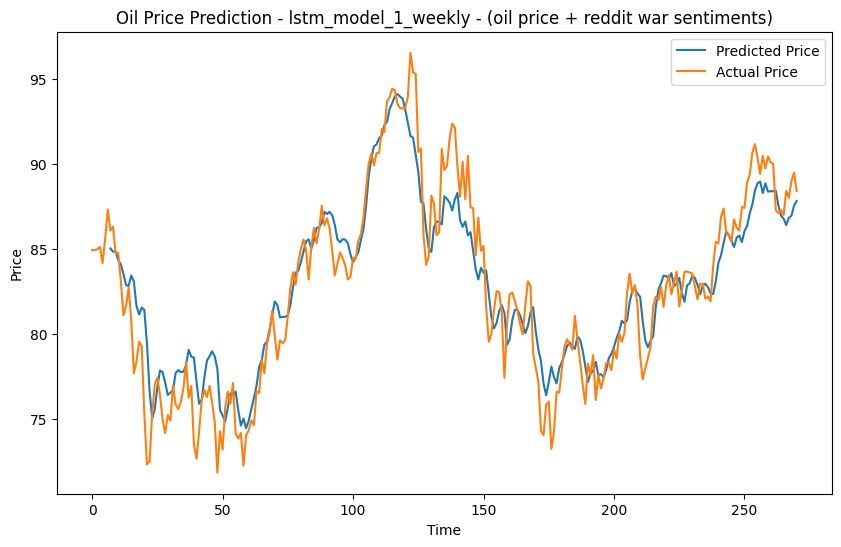

257/257 [==============================] - 1s 2ms/step


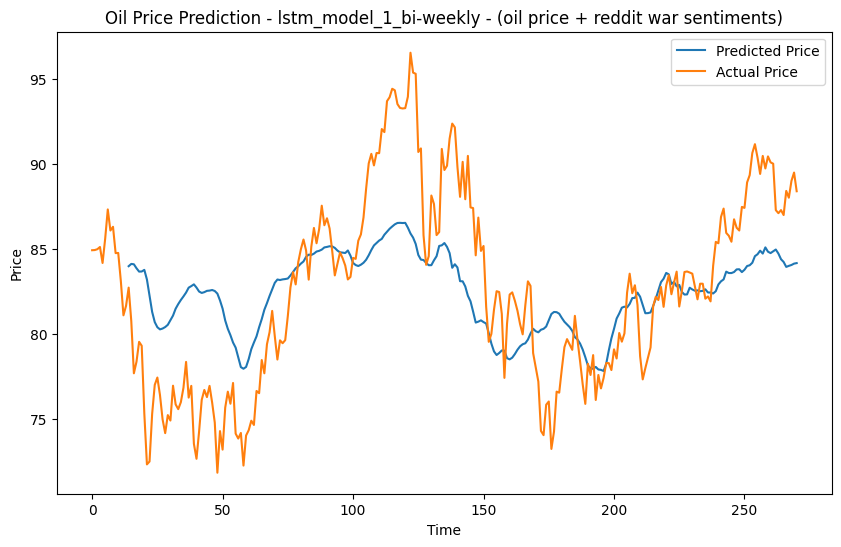

241/241 [==============================] - 1s 2ms/step


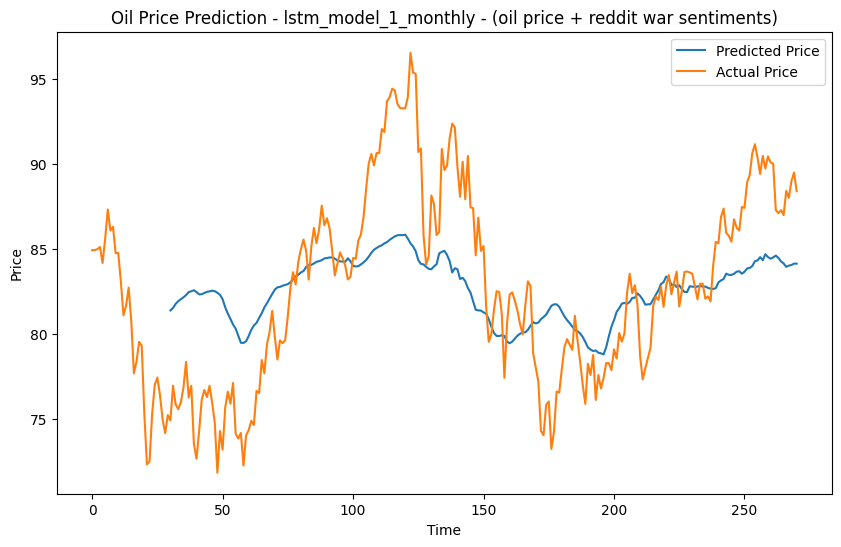

264/264 [==============================] - 1s 2ms/step


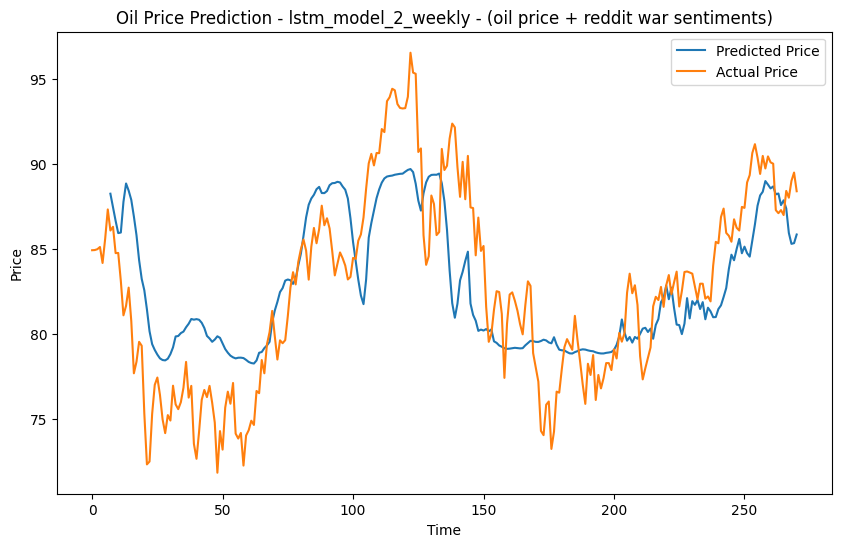

257/257 [==============================] - 2s 2ms/step


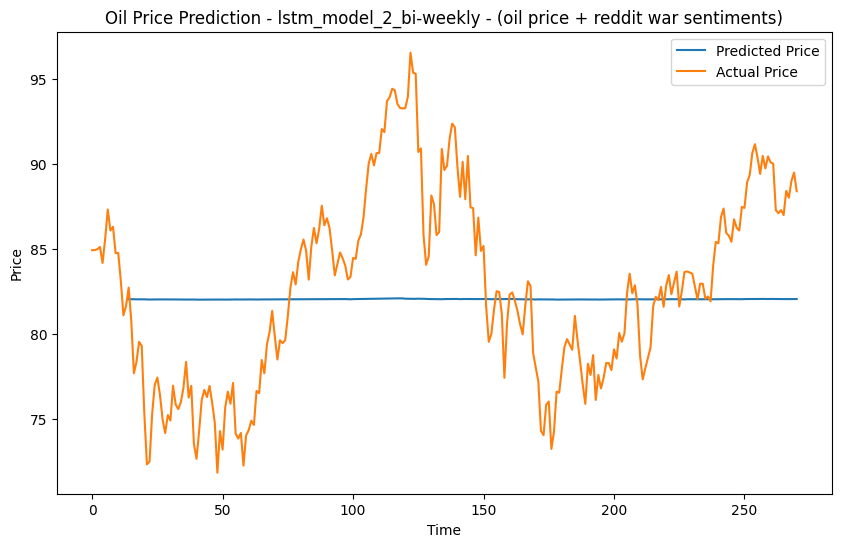

241/241 [==============================] - 2s 3ms/step


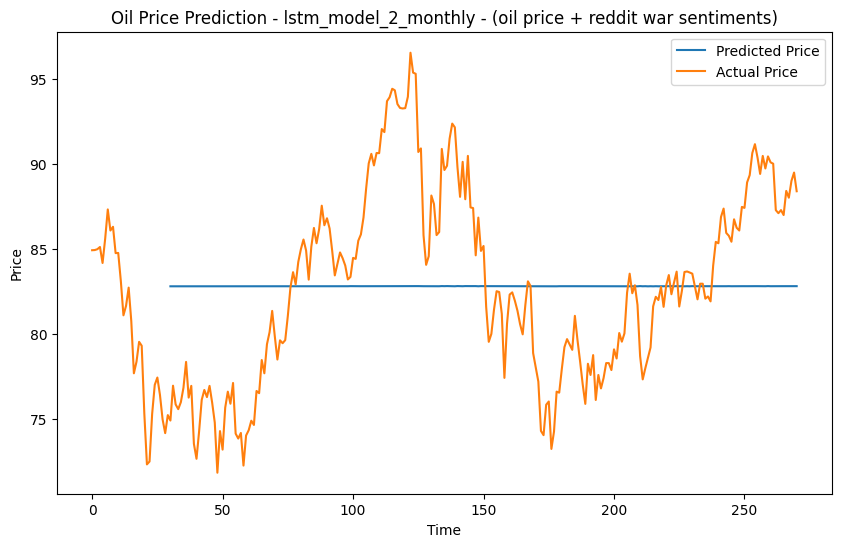

264/264 [==============================] - 3s 2ms/step


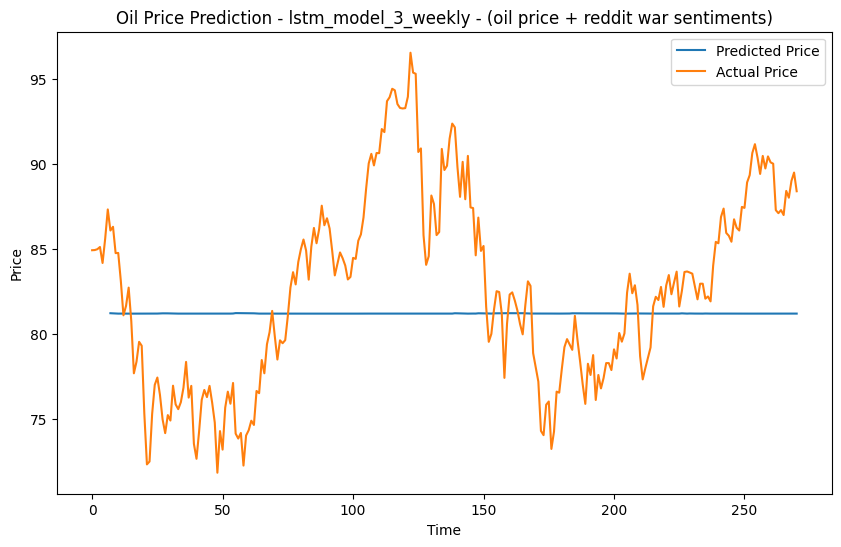

257/257 [==============================] - 3s 3ms/step


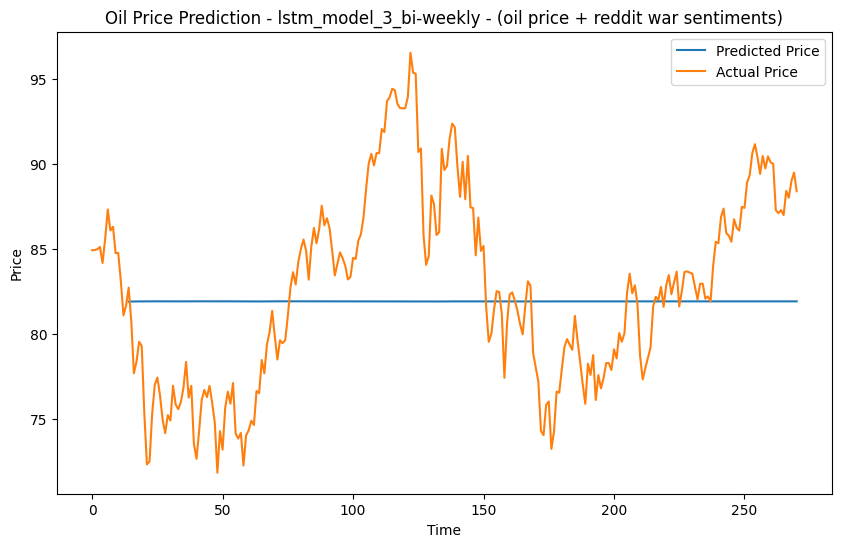

241/241 [==============================] - 3s 5ms/step


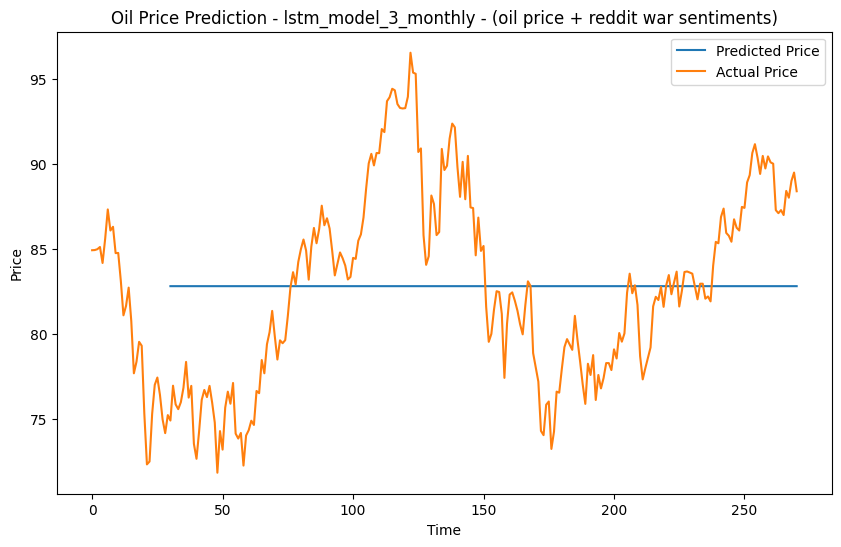

264/264 [==============================] - 1s 2ms/step


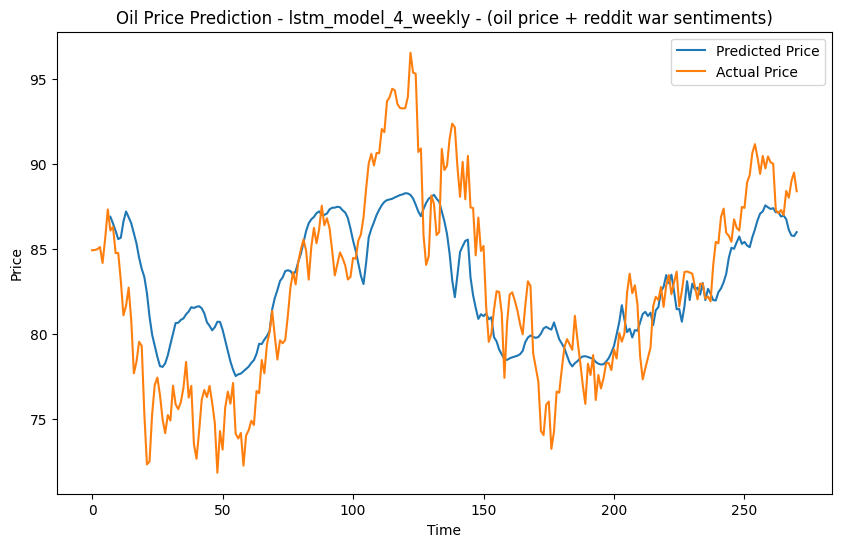

257/257 [==============================] - 2s 2ms/step


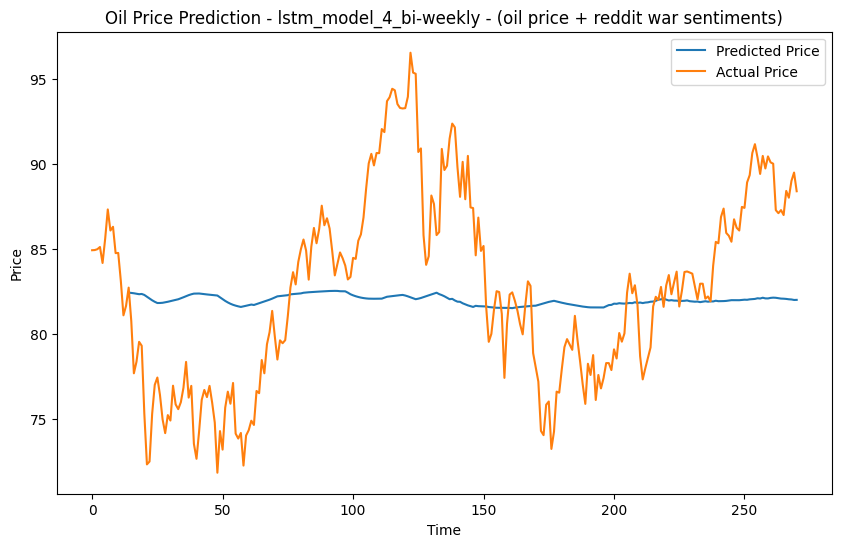

241/241 [==============================] - 2s 3ms/step


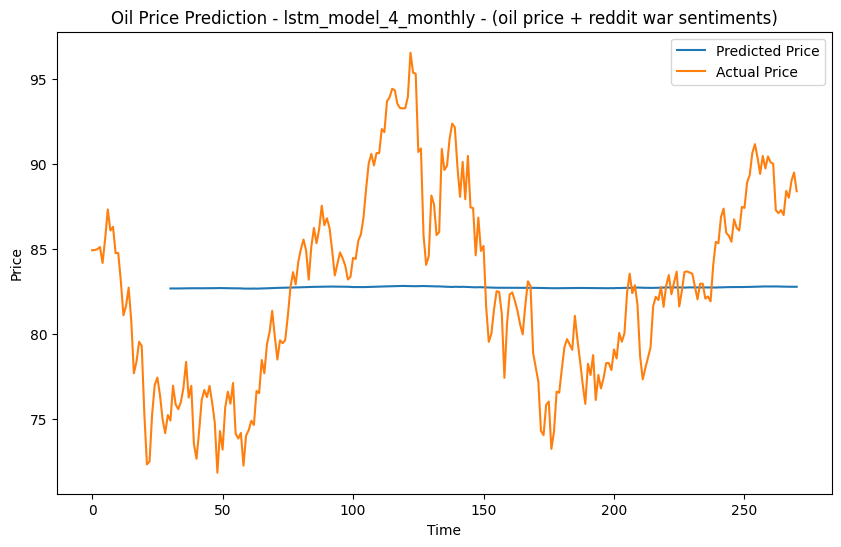

264/264 [==============================] - 2s 1ms/step


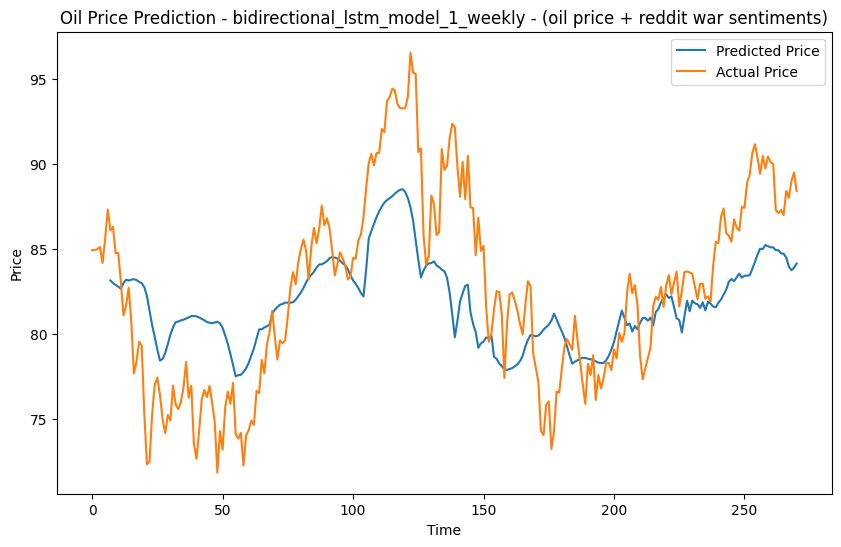

257/257 [==============================] - 2s 2ms/step


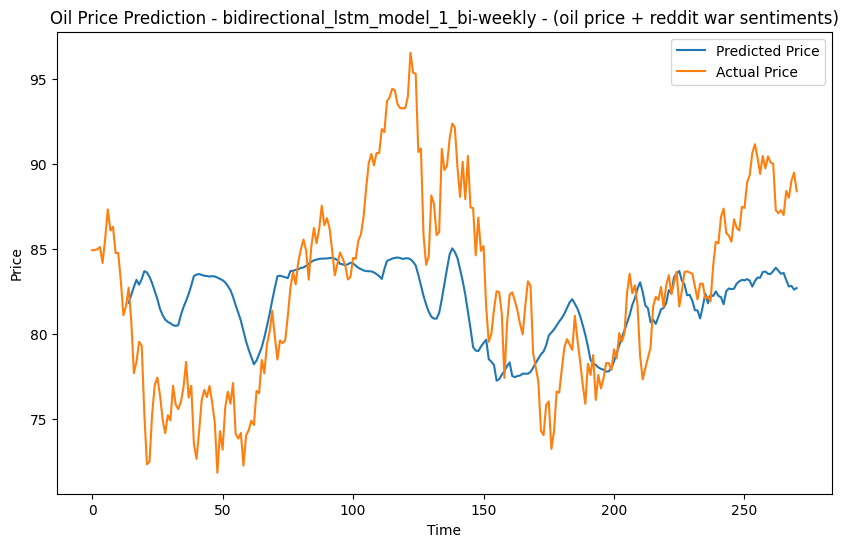

241/241 [==============================] - 2s 3ms/step


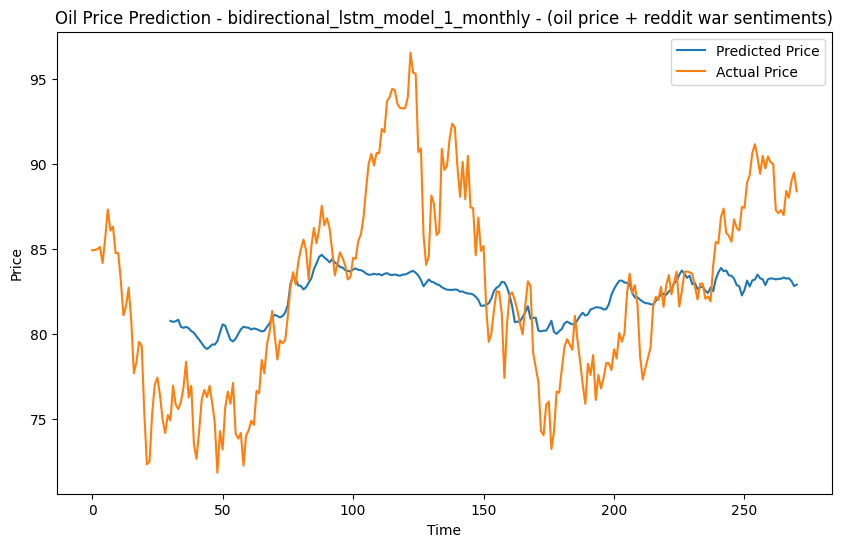

264/264 [==============================] - 2s 1ms/step


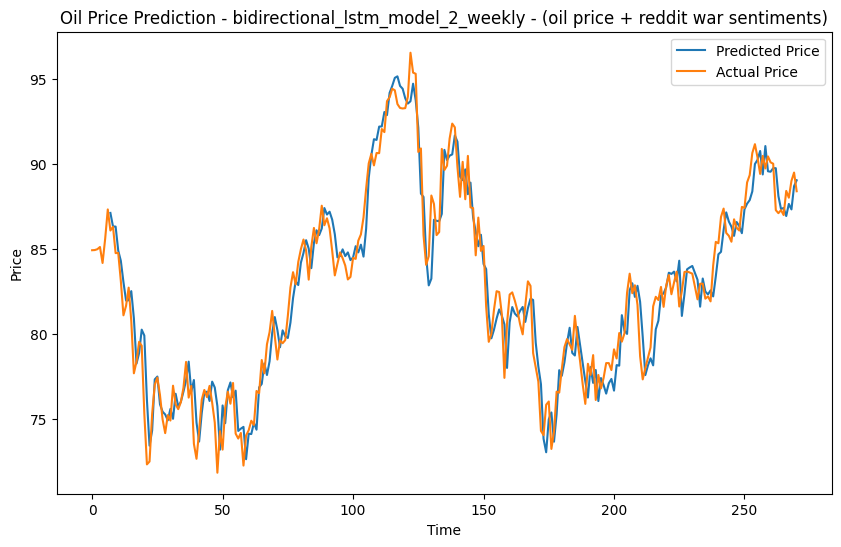

257/257 [==============================] - 2s 2ms/step


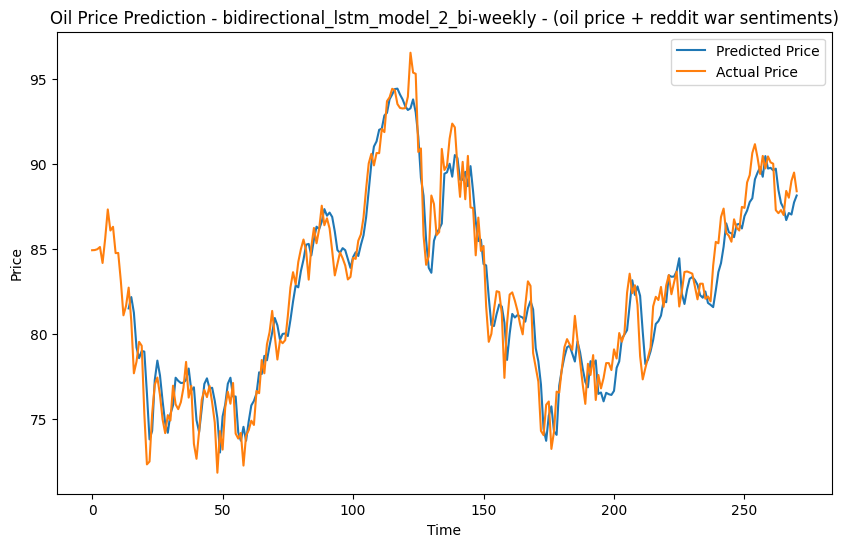

241/241 [==============================] - 2s 3ms/step


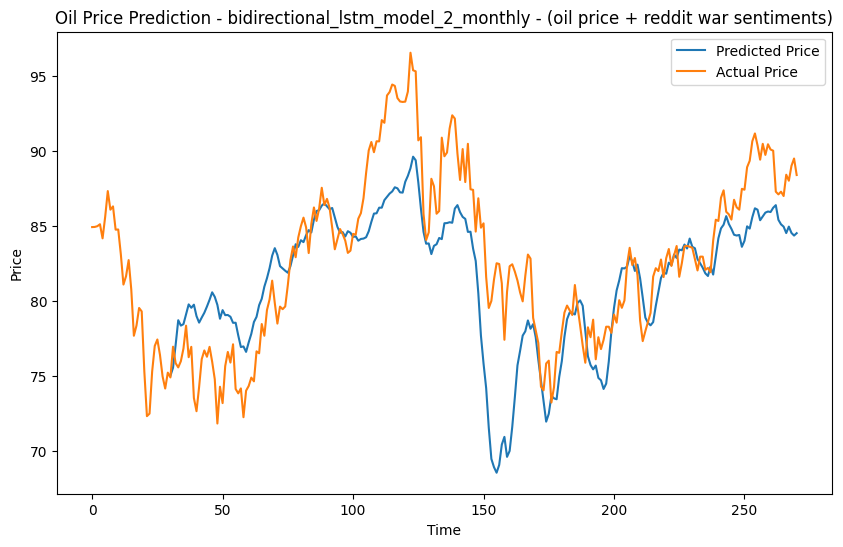

264/264 [==============================] - 2s 2ms/step


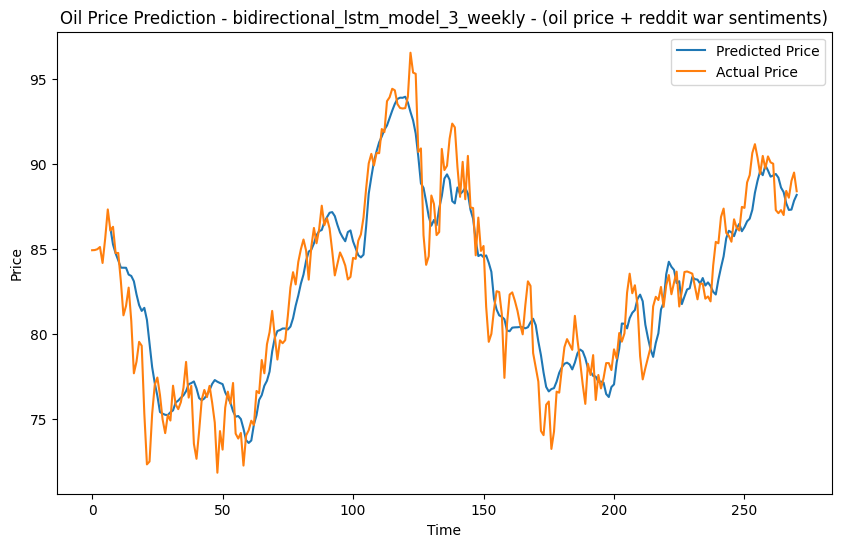

257/257 [==============================] - 2s 2ms/step


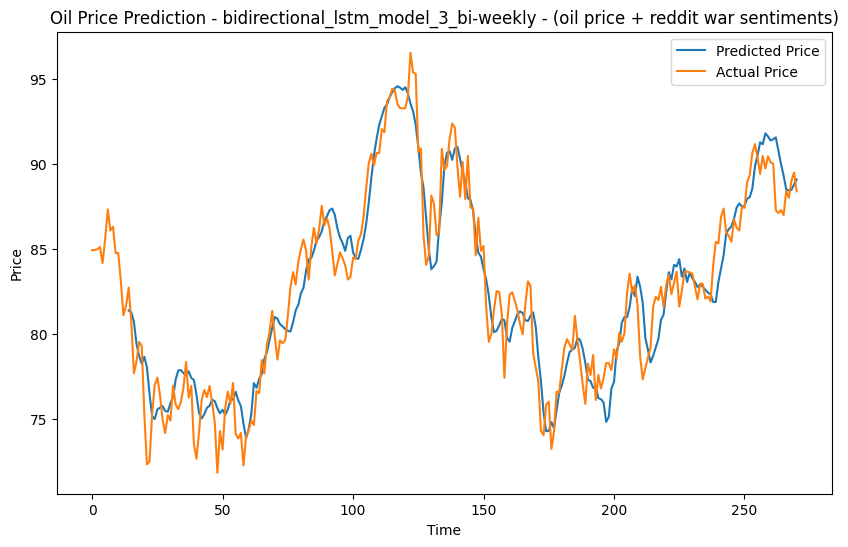

241/241 [==============================] - 3s 3ms/step


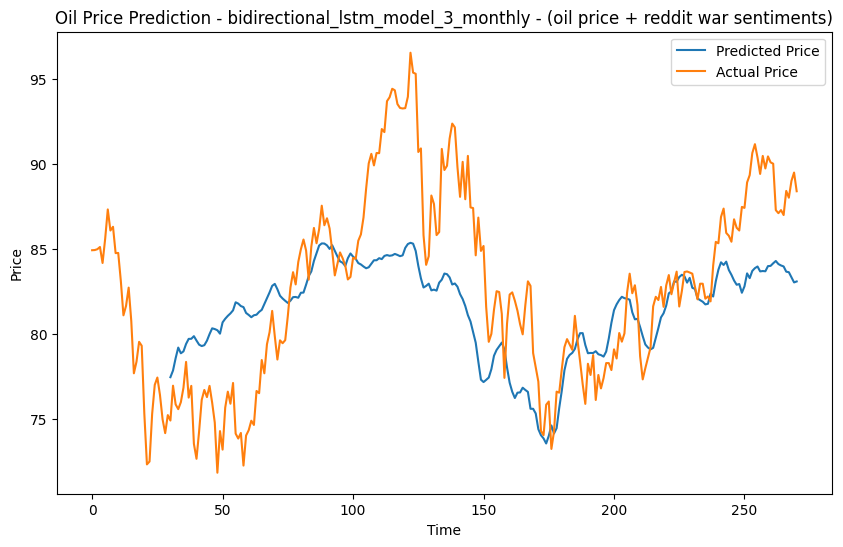

264/264 [==============================] - 2s 1ms/step


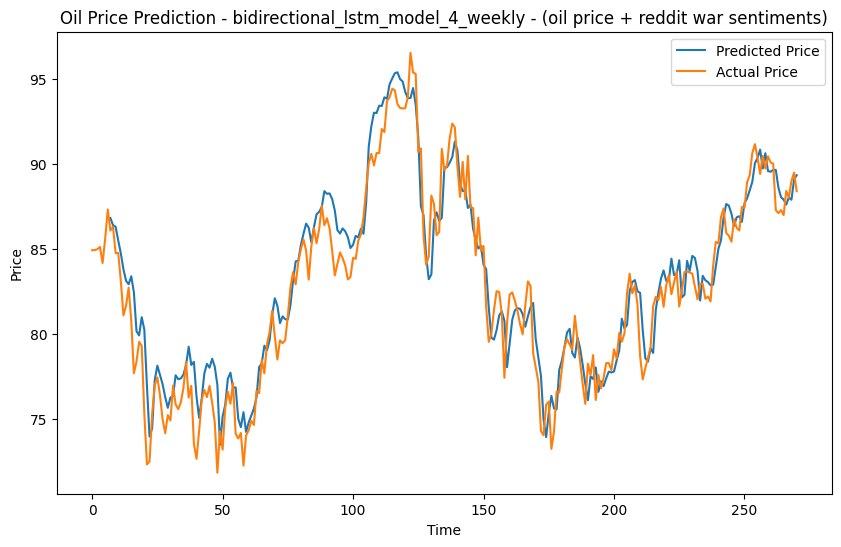

257/257 [==============================] - 2s 2ms/step


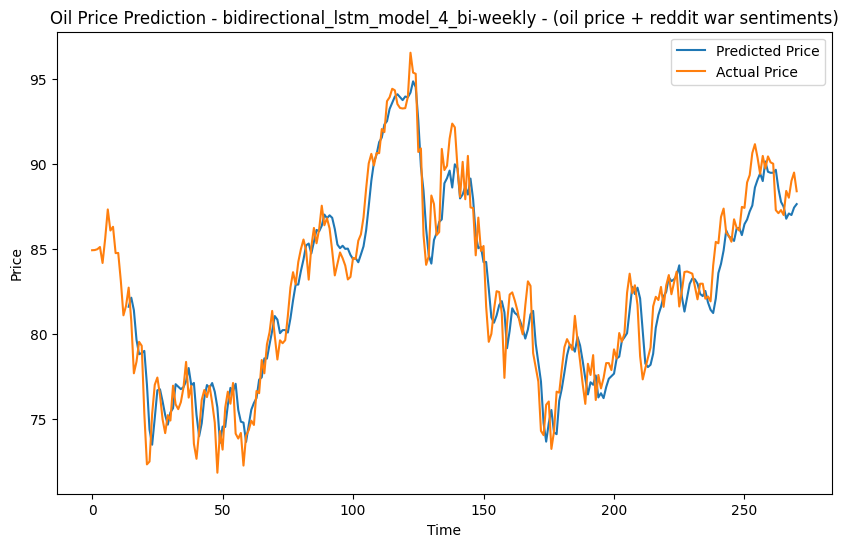

241/241 [==============================] - 2s 3ms/step


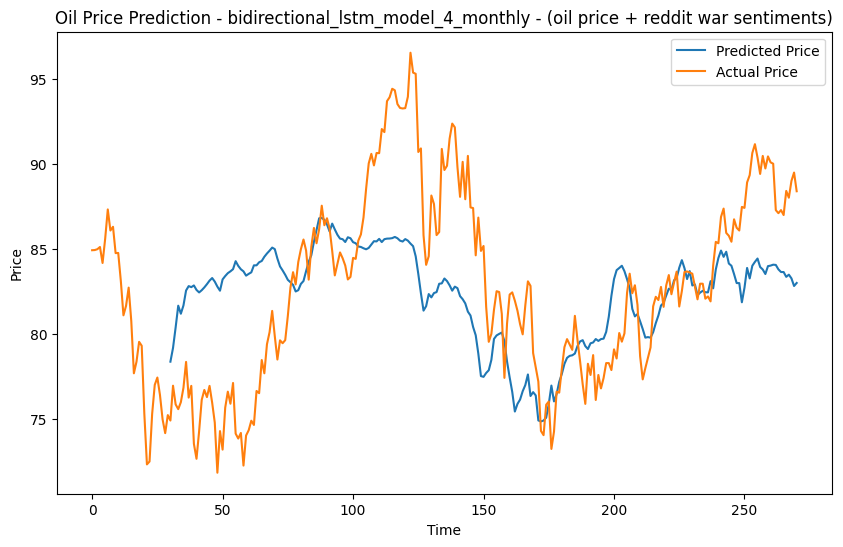

264/264 [==============================] - 2s 2ms/step


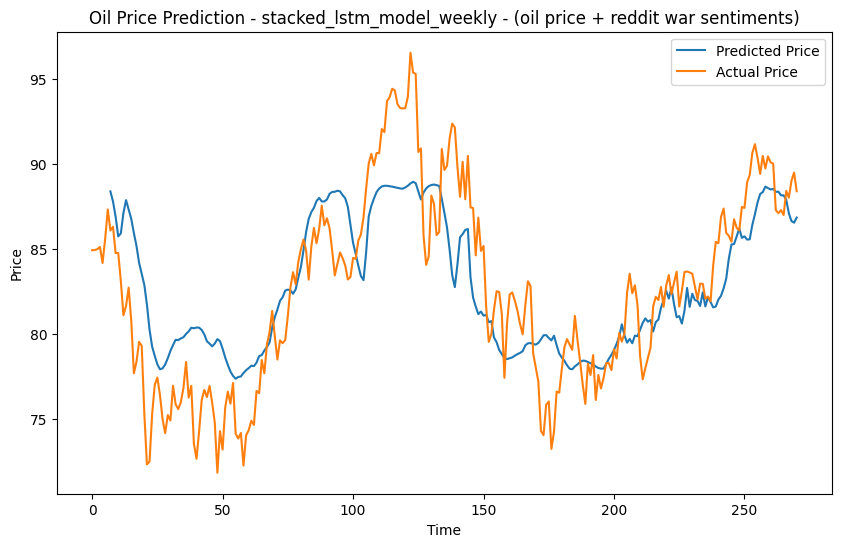

257/257 [==============================] - 2s 2ms/step


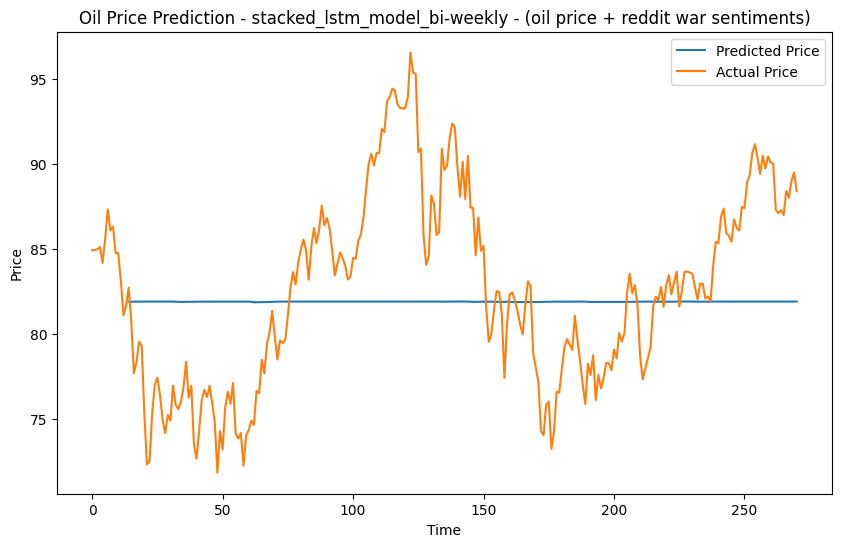

241/241 [==============================] - 2s 3ms/step


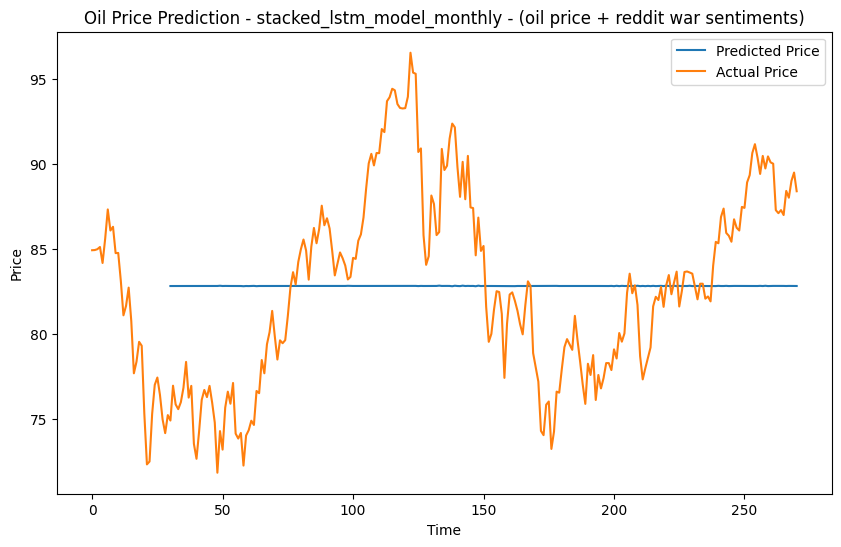

264/264 [==============================] - 1s 982us/step
Error attention_lstm_model_weekly (264, 7, 1)
257/257 [==============================] - 1s 1ms/step
Error attention_lstm_model_bi-weekly (257, 14, 1)
241/241 [==============================] - 1s 1ms/step
Error attention_lstm_model_monthly (241, 30, 1)


In [65]:
# Plot predictions vs actual values

# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    seq_length = models_list[model_name]['seq_length']

    all_predict = model.predict(window.all_data)
    try:

        X_all_data = scaler.inverse_transform(all_predict)

        plt.figure(figsize=(10, 6))
        plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
        plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
        plt.title(f'Oil Price Prediction - {model_name} - (oil price + reddit war sentiments)')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.savefig(f'outputs/oil_reddit_war/LSTM {model_name} Oil Price Prediction.png')
        plt.show()
    except:
        print("Error", model_name, all_predict.shape)